In [15]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))


import tensorflow as tf
import bayesflow as bf
import numpy as np


from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.summary_networks import DeepSet, HierarchicalNetwork

from src.networks import AmortizedSmoothing, AmortizedPosteriorMixture, Classifier
from src.models.HmmEam import model, configurator, constrain_parameters, constrained_parameter_names


train = True

In [2]:
local_summary_net = DeepSet(summary_dim=2)
classification_net = Sequential([
    LSTM(units=32, return_sequences=True), 
    Classifier(n_classes=2, n_units=[16, 8, 4])
])

amortizer = AmortizedPosteriorMixture(
    amortized_posterior=AmortizedPosterior(
        inference_net=InvertibleNetwork(num_params=8, num_coupling_layers=10, coupling_design="spline"),
        summary_net=HierarchicalNetwork([local_summary_net, SequenceNetwork(summary_dim=24, bidirectional=True)]),
        summary_loss_fun="MMD"
    ),
    amortized_mixture=AmortizedSmoothing(
        forward_net=classification_net, 
        backward_net=classification_net, 
        local_summary_net=local_summary_net
    )
)

In [3]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configurator, checkpoint_path="checkpoints/training")

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [4]:
%time
if train:
    h = trainer.train_online(epochs=200, iterations_per_epoch=100, batch_size=128)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


Training epoch 200: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it, Epoch: 200, Iter: 100,forward.loss: 0.420,backward.loss:: 0.419,posterior.loss: 1.515,W.Decay: 0.151,Avg.forward.loss: 0.435,Avg.backward.loss:: 0.435,Avg.posterior.loss: 1.434,Avg.W.Decay: 0.151,LR: 0.00E+00]


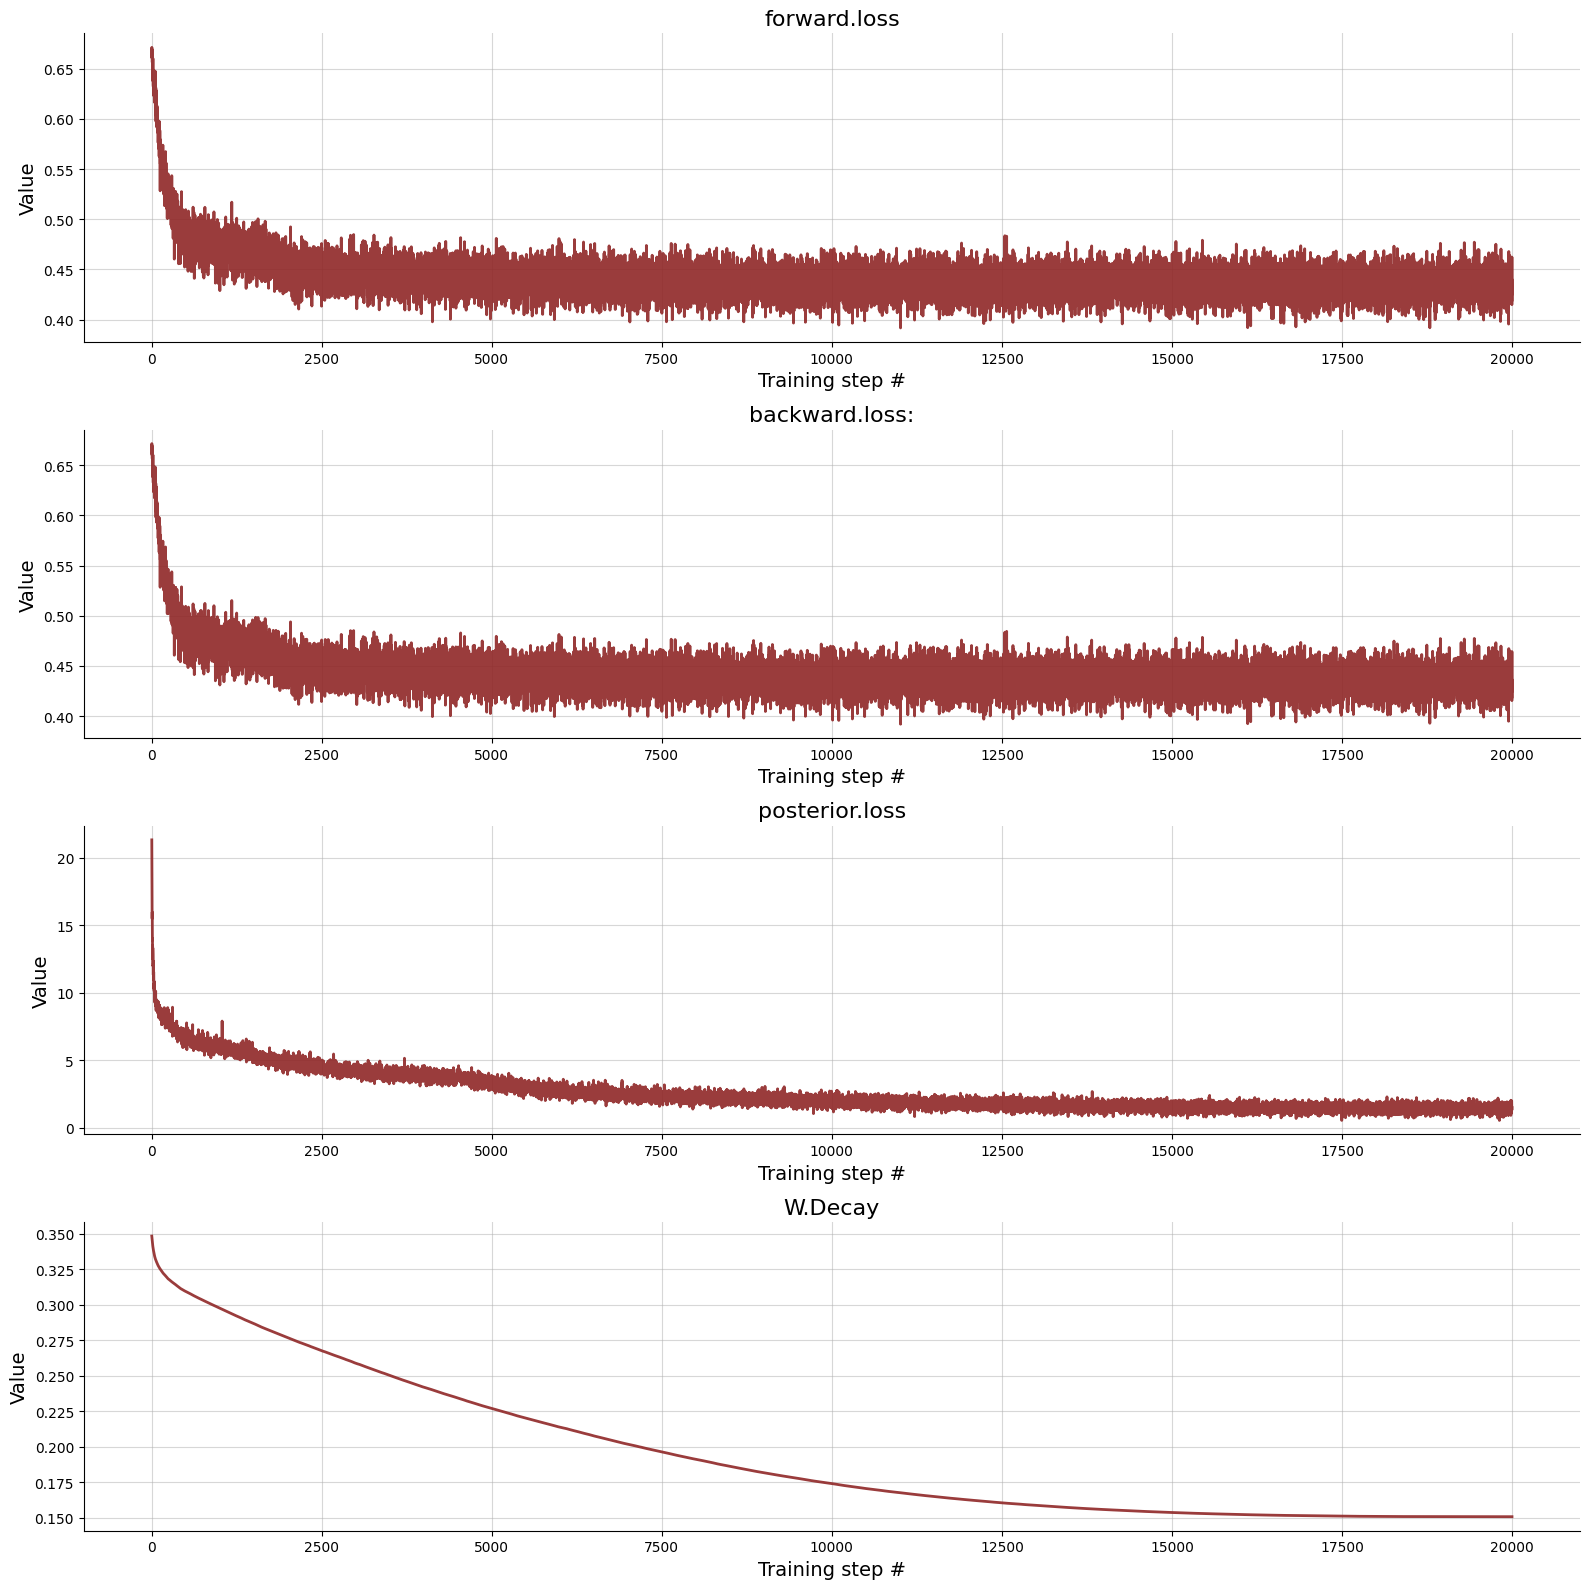

In [5]:
if train:
    f  = bf.diagnostics.plot_losses(h)

In [6]:
df = configurator(model(1000))

In [7]:
(z, _), _ = amortizer(df)

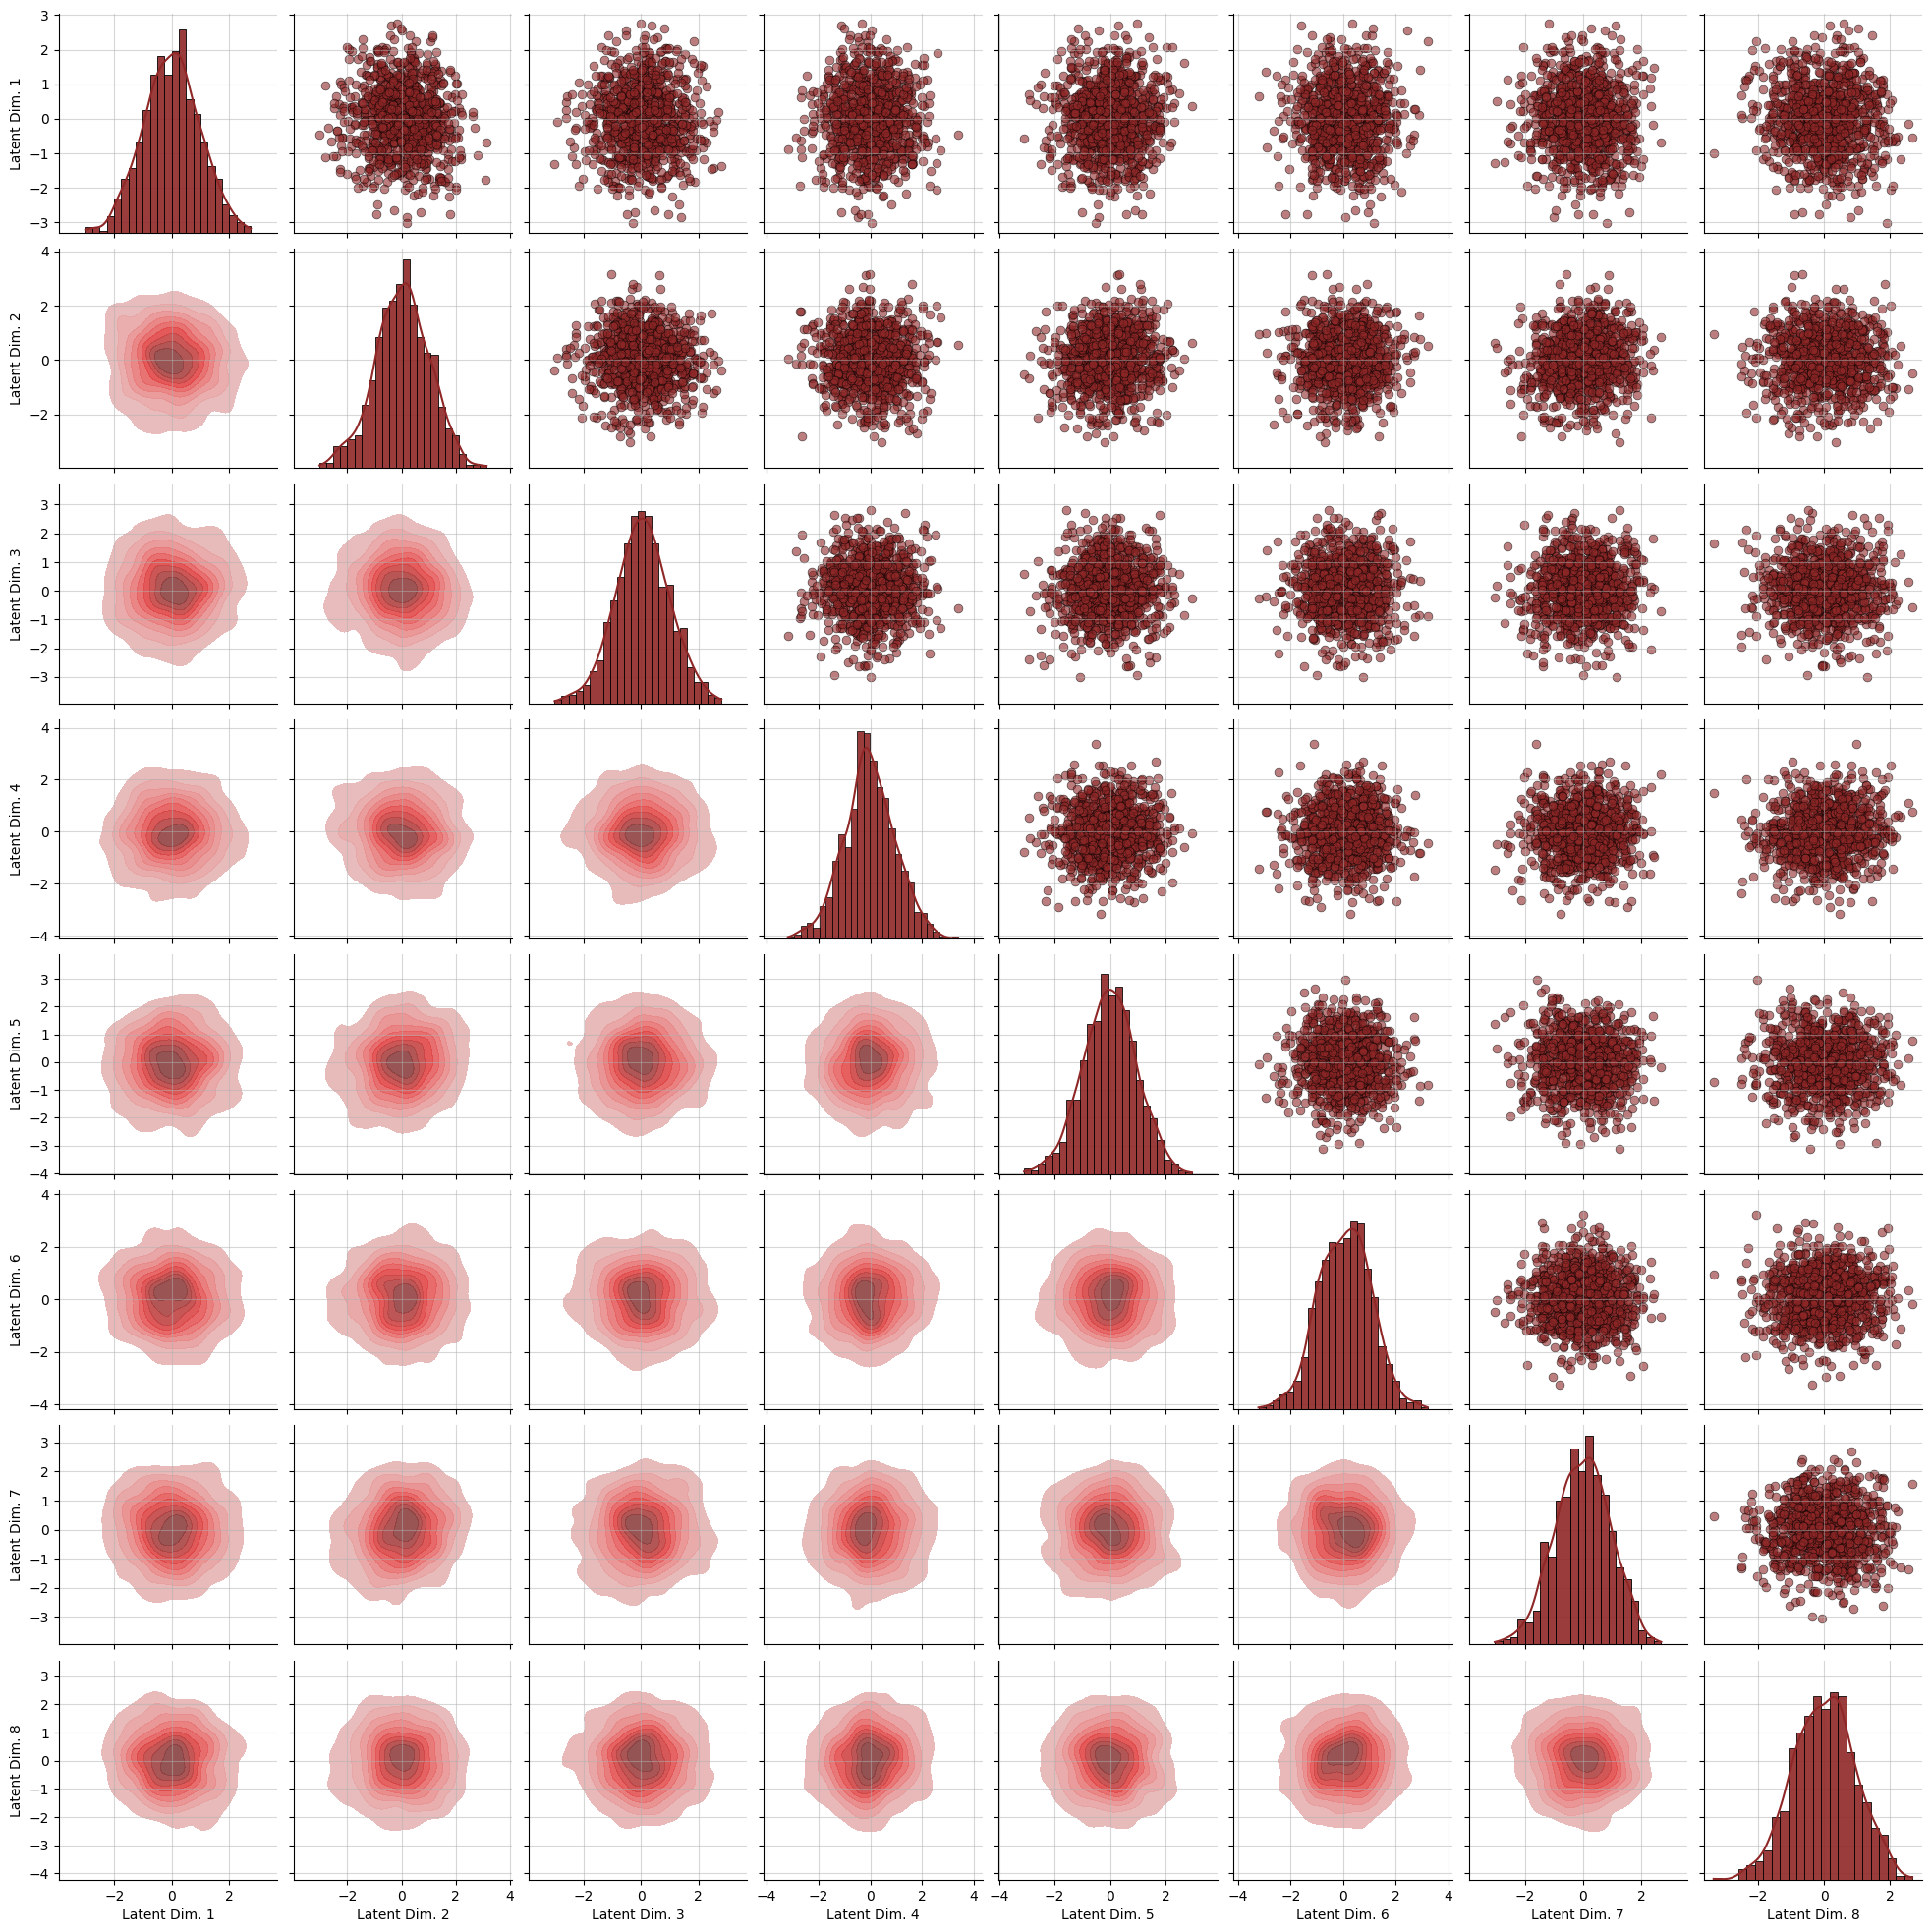

In [8]:
f = bf.diagnostics.plot_latent_space_2d(z)

## Calibration (parameter posterior approximator)

### Unconstrained space

In [9]:
prior = df['posterior_inputs']['parameters']
posterior = amortizer.amortized_posterior.sample(df['posterior_inputs'], n_samples=1000)

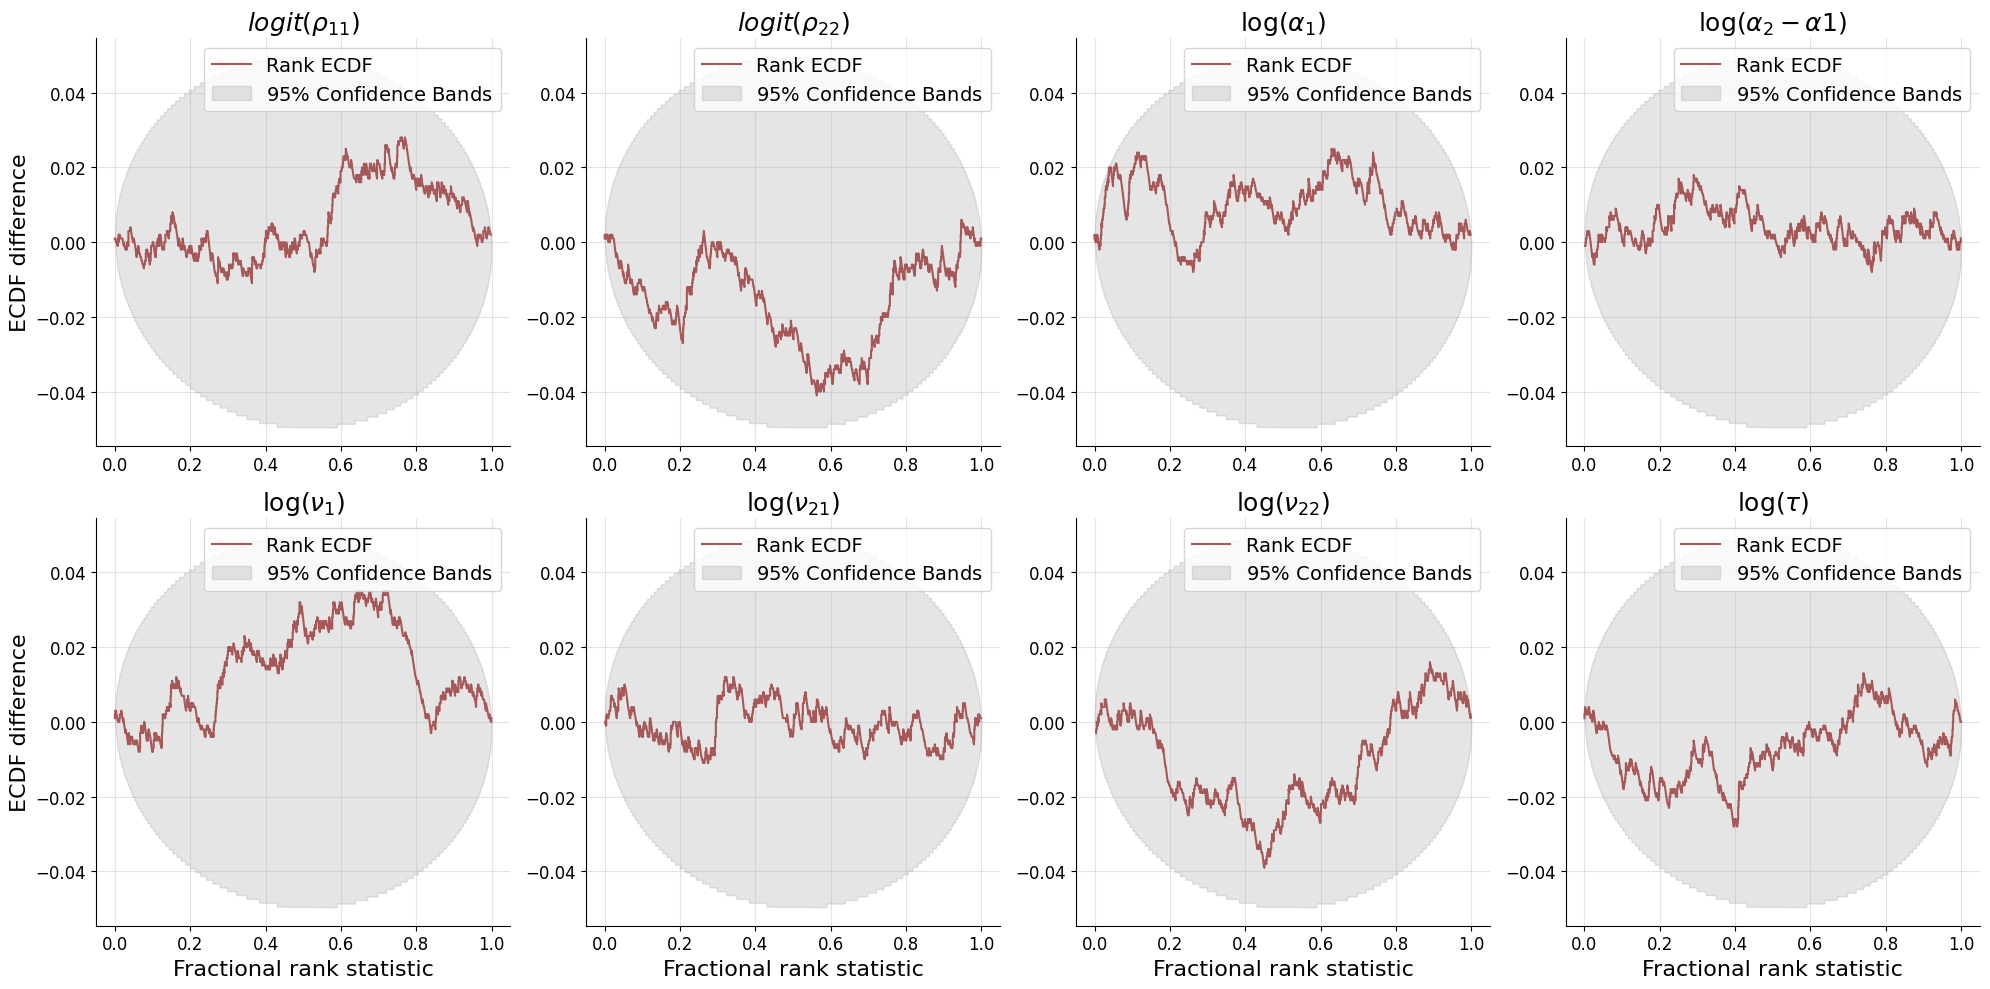

In [10]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, difference=True, param_names=model.param_names)

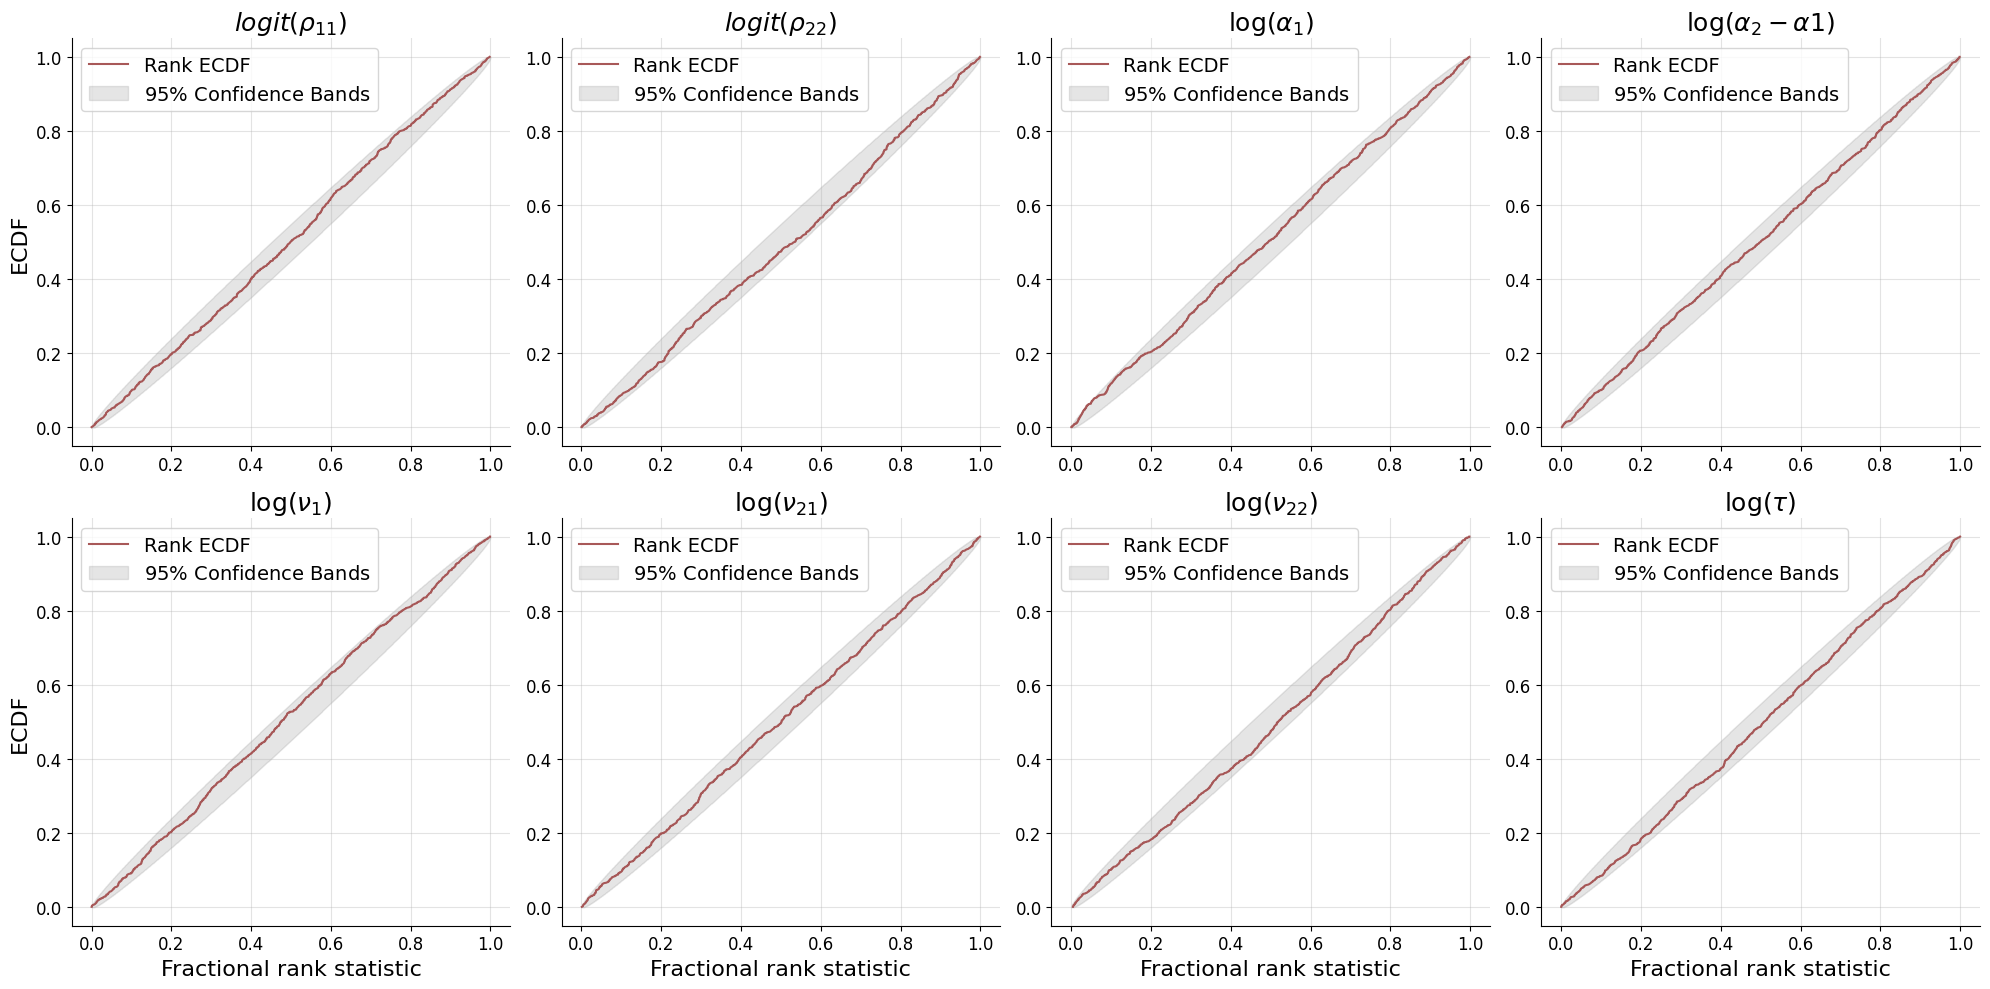

In [11]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, param_names=model.param_names)

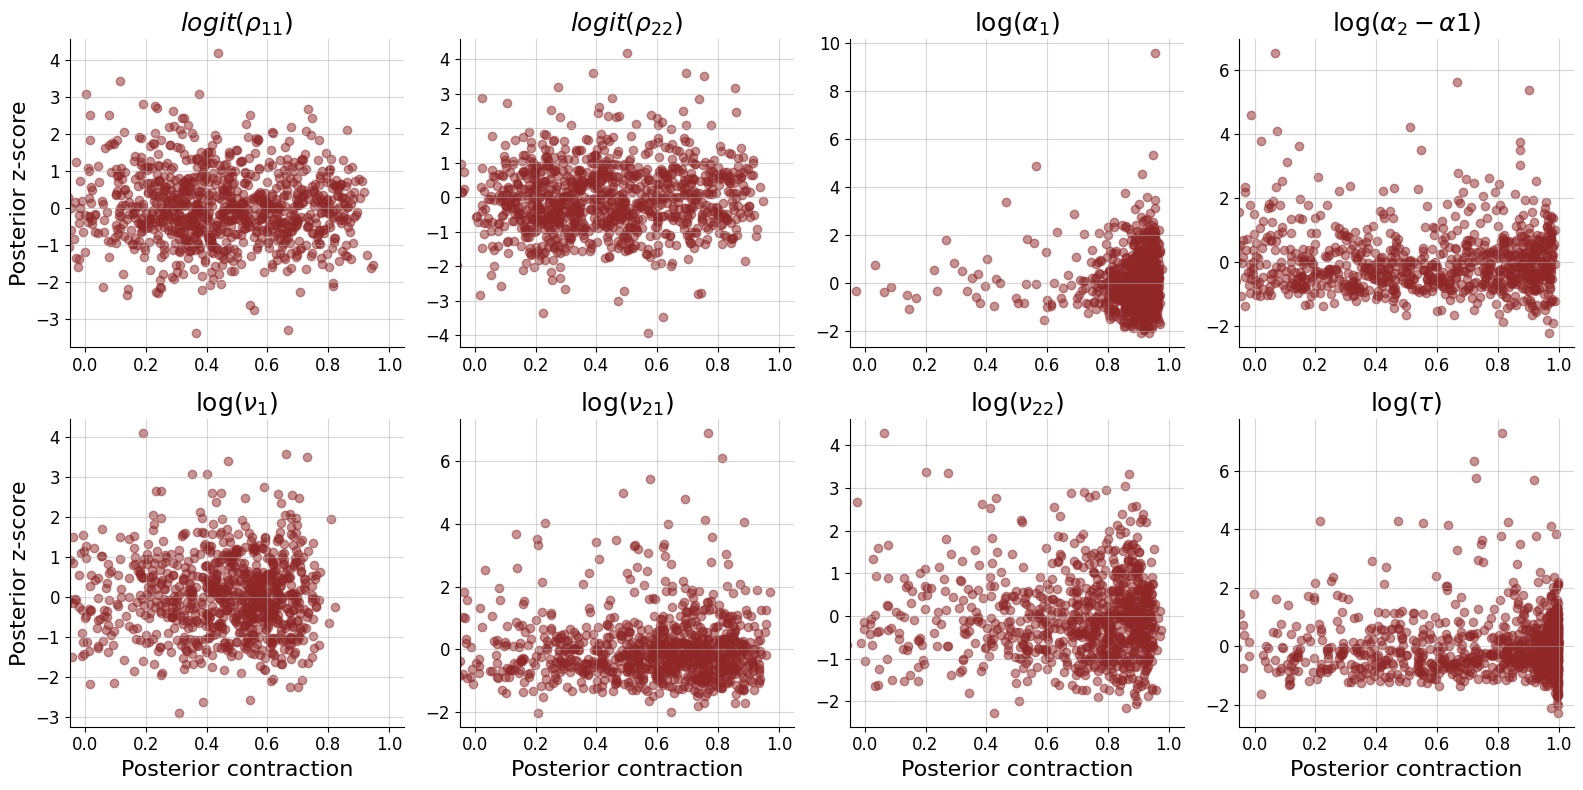

In [12]:
f = bf.diagnostics.plot_z_score_contraction(posterior, prior, param_names=model.param_names)

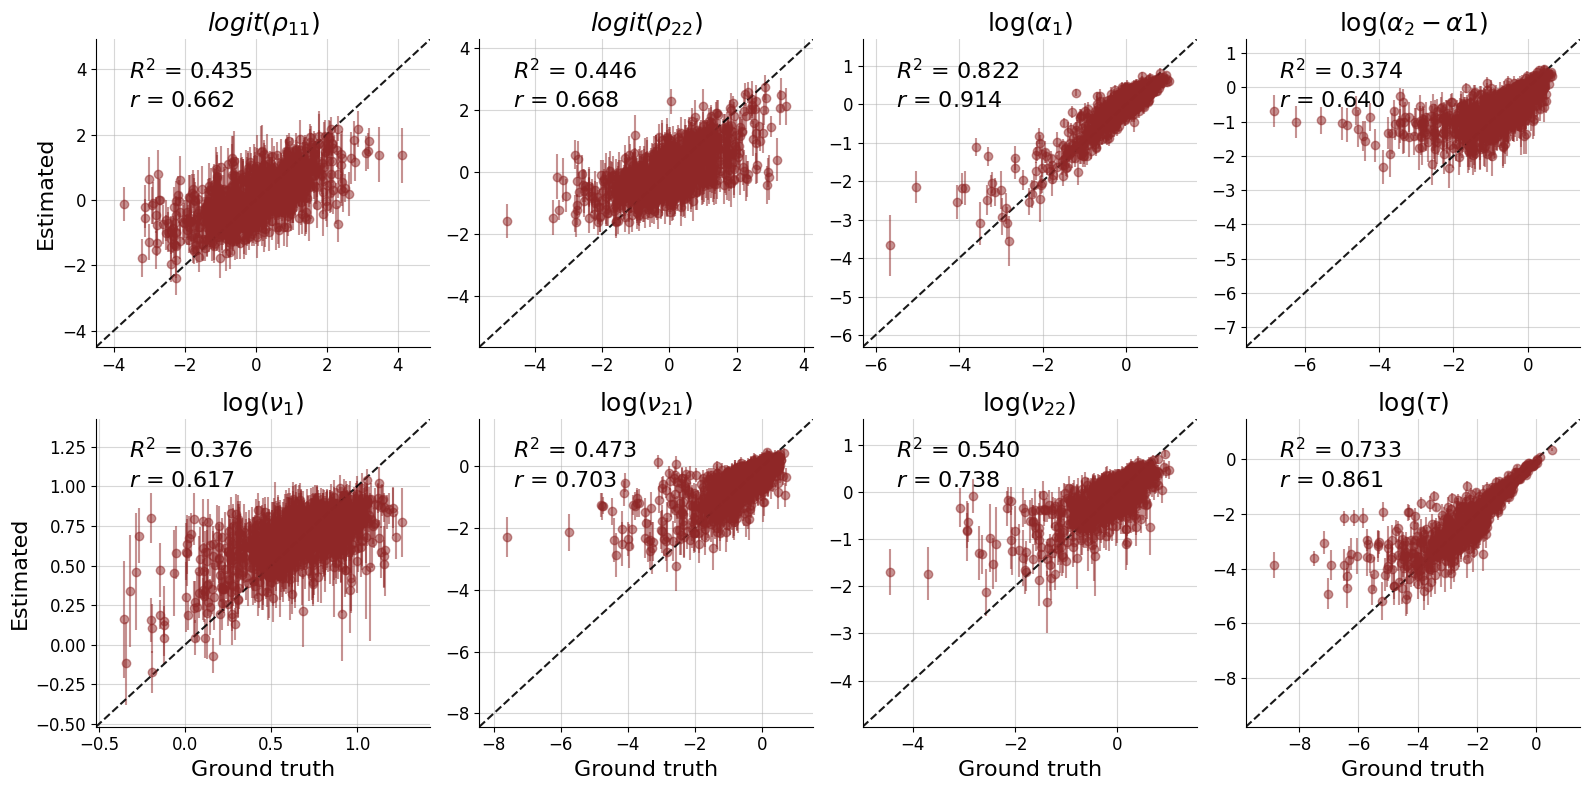

In [13]:
f = bf.diagnostics.plot_recovery(posterior, prior, param_names=model.param_names)

### Constrained space

In [14]:
prior = constrain_parameters(prior)
posterior = constrain_parameters(posterior)

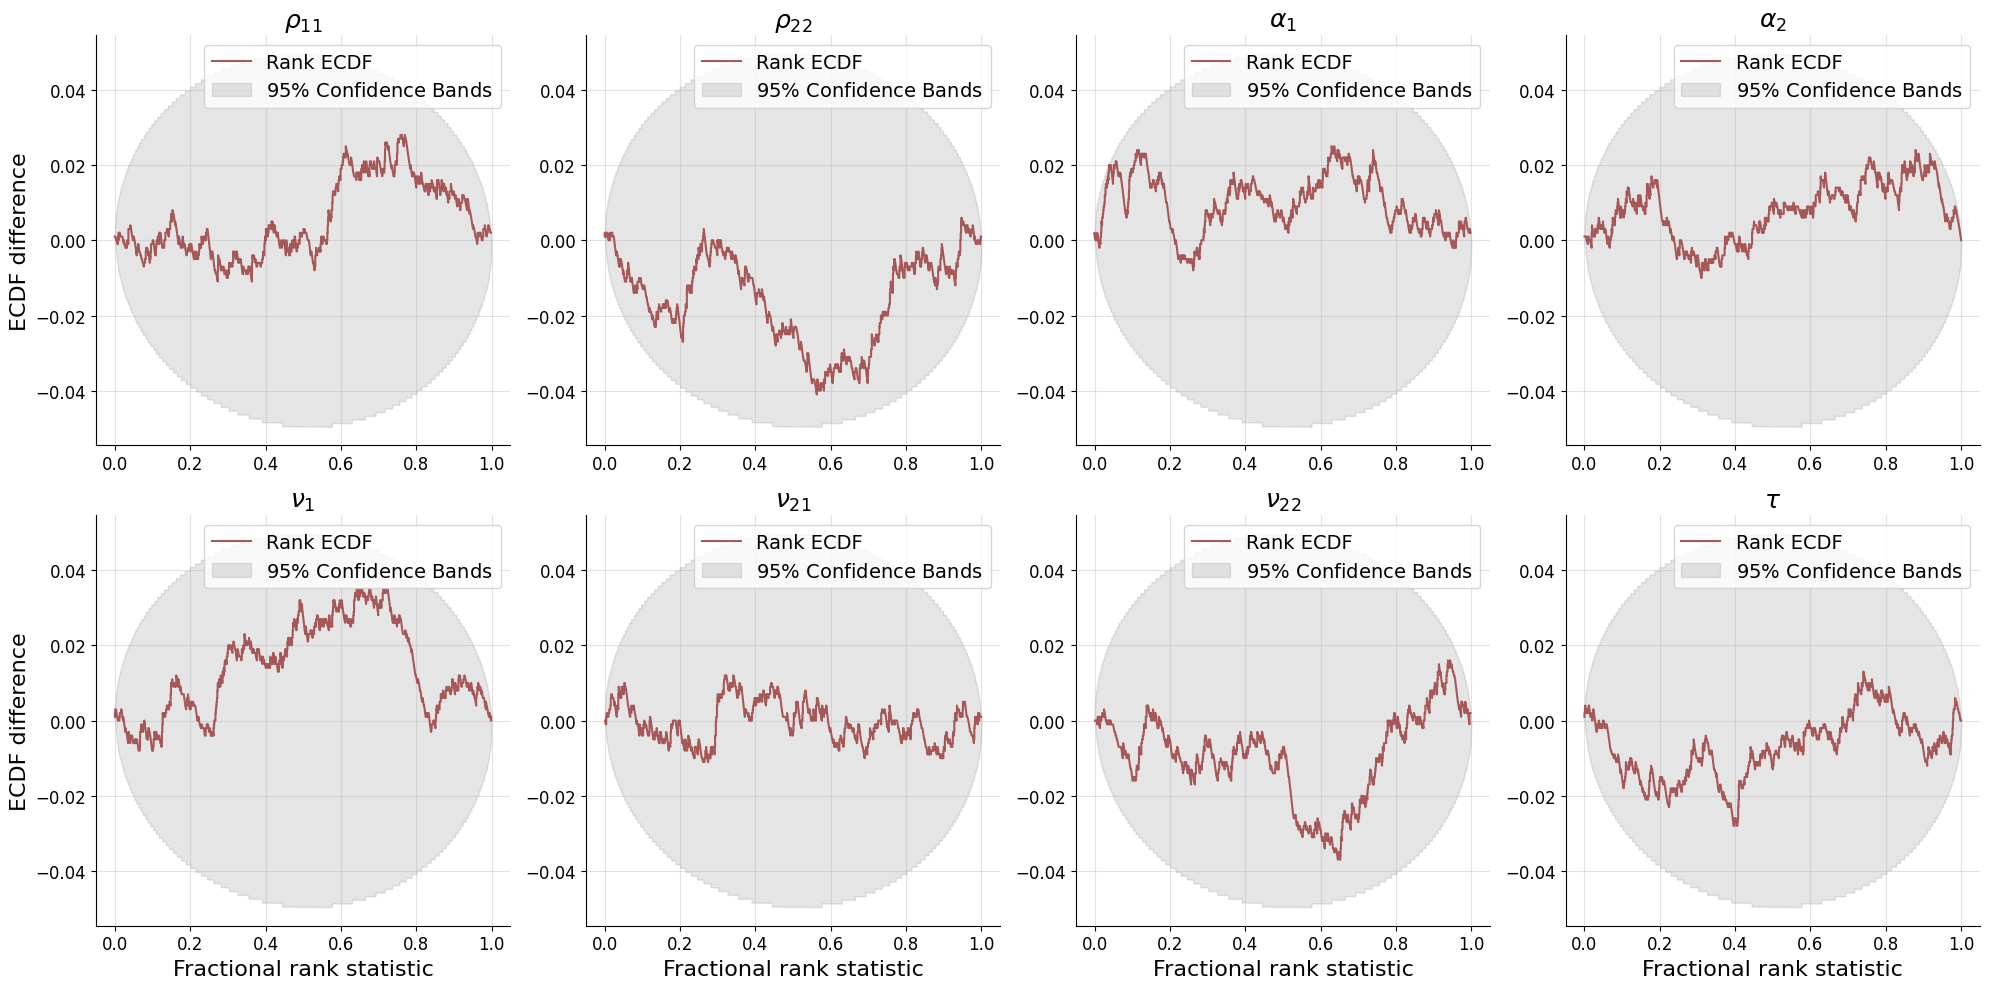

In [16]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, difference=True, param_names=constrained_parameter_names)

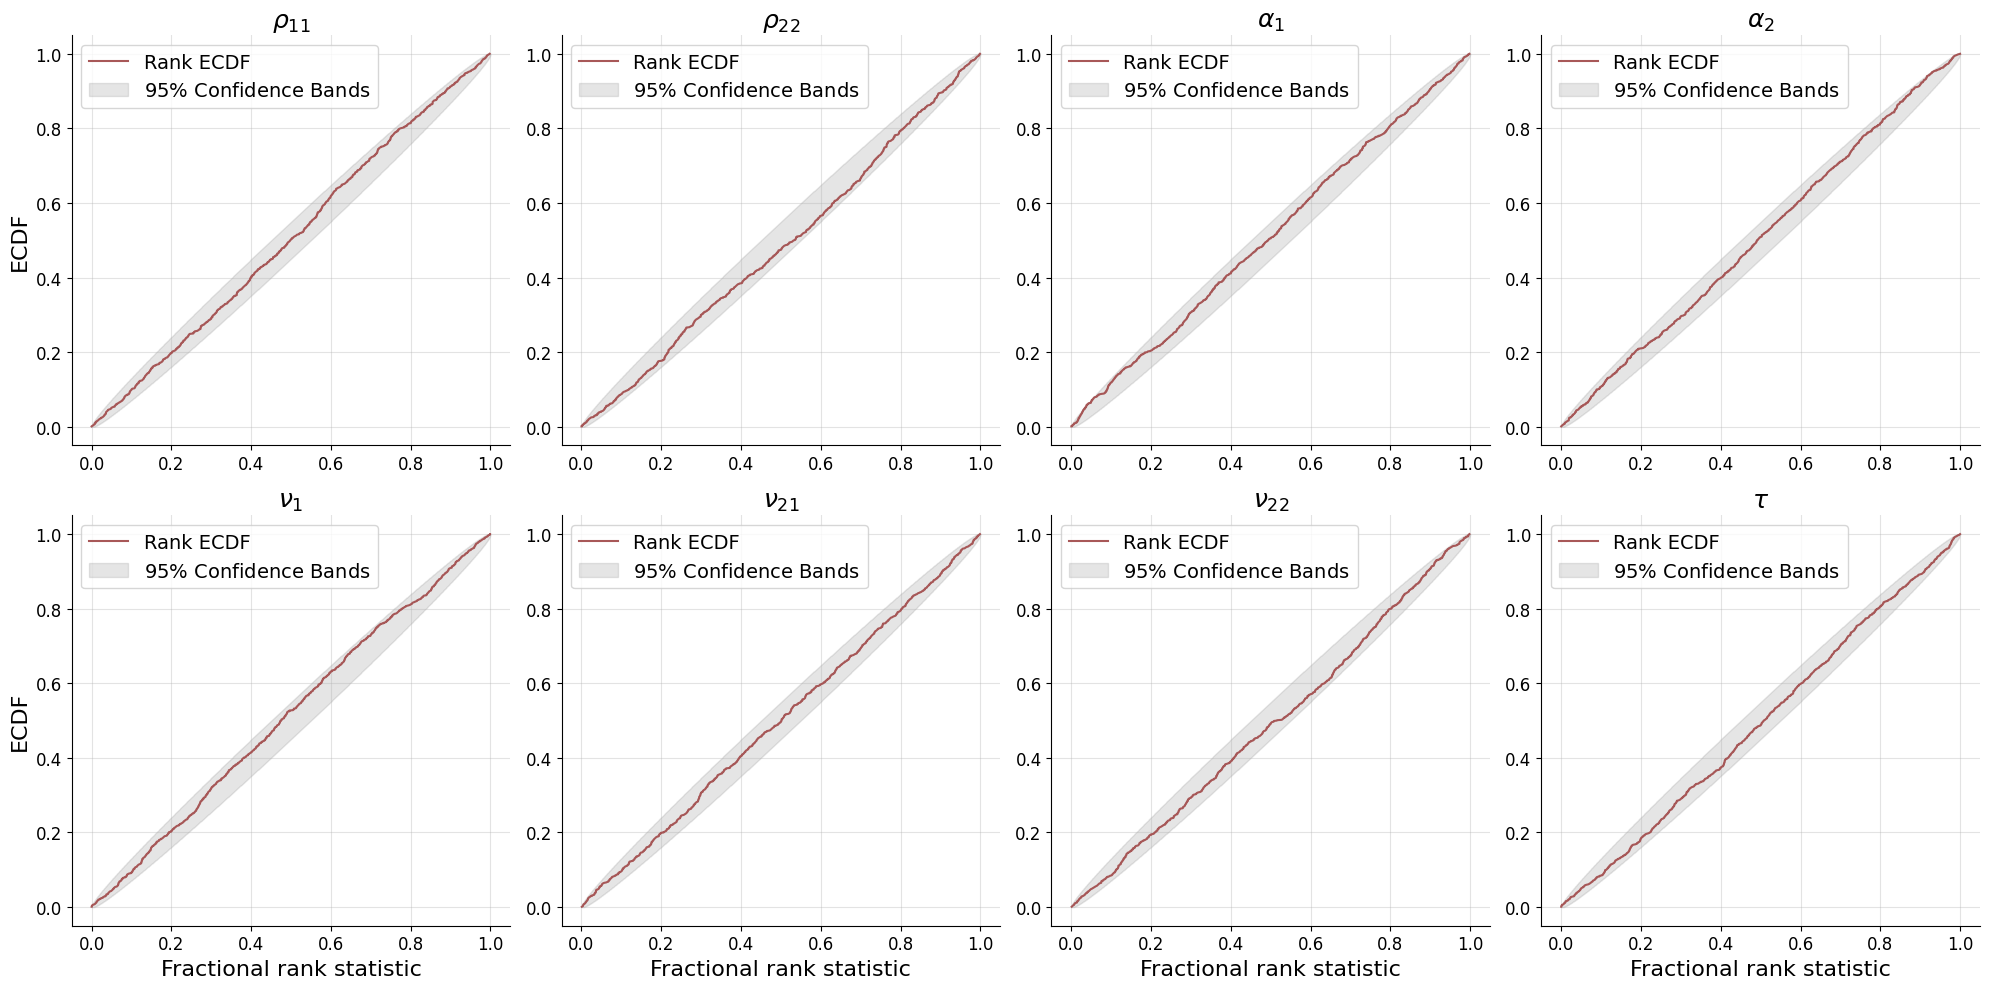

In [17]:
f = bf.diagnostics.plot_sbc_ecdf(posterior, prior, param_names=constrained_parameter_names)

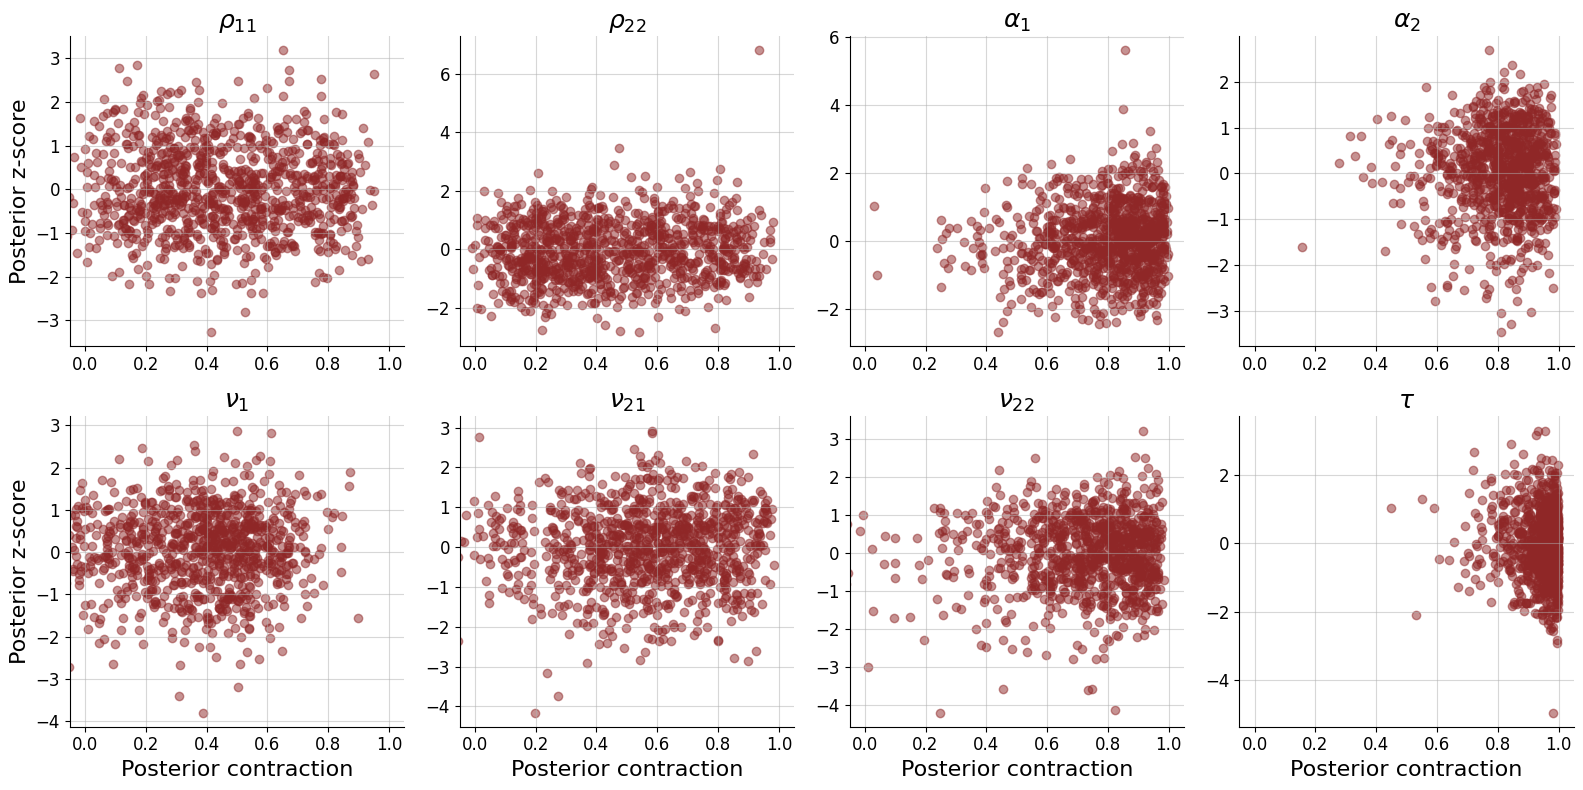

In [18]:
f = bf.diagnostics.plot_z_score_contraction(posterior, prior, param_names=constrained_parameter_names)

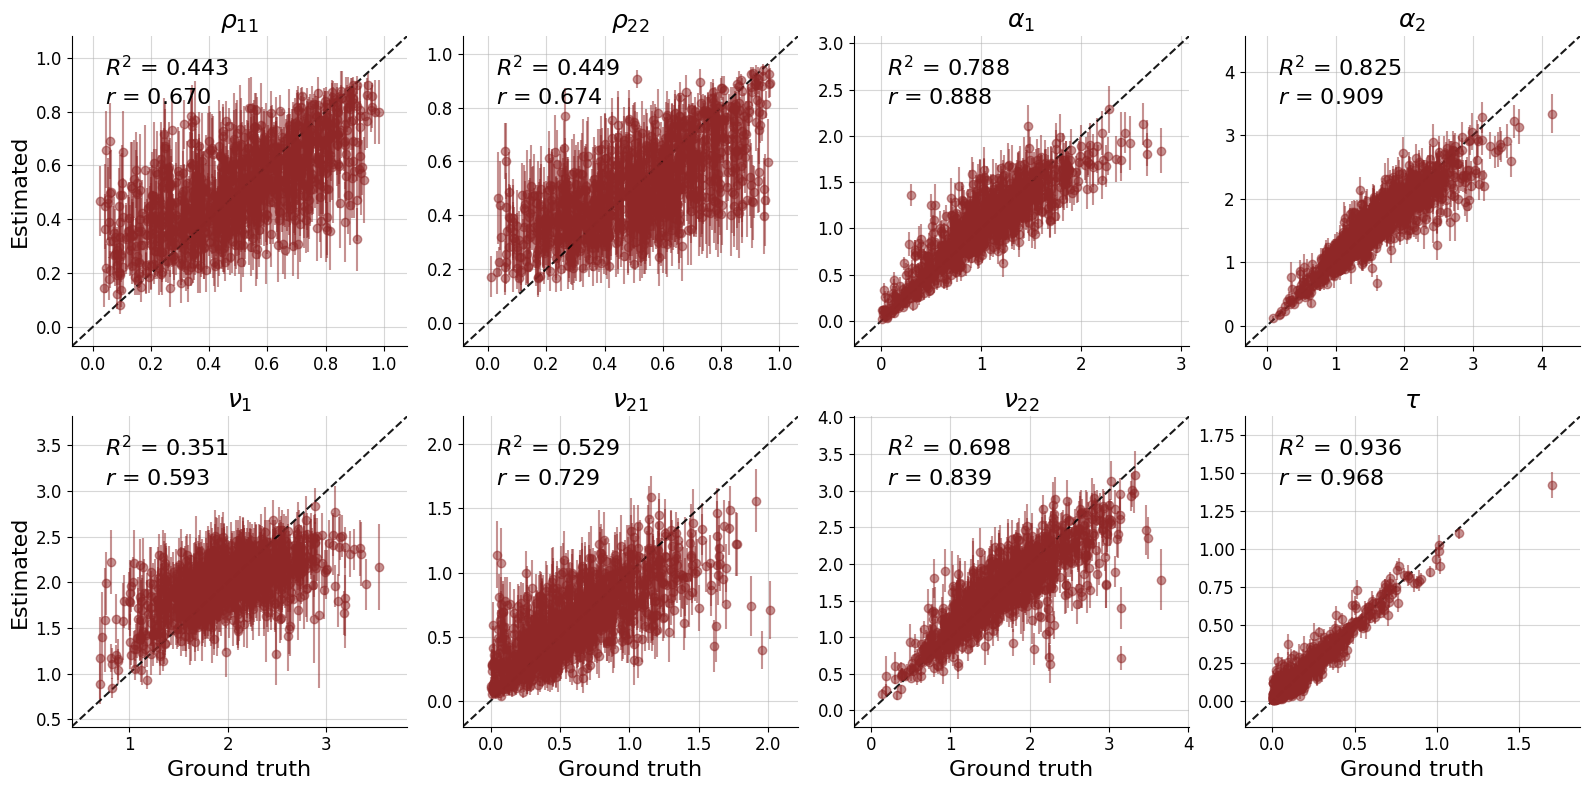

In [19]:
f = bf.diagnostics.plot_recovery(posterior, prior, param_names=constrained_parameter_names)